In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [3]:
def convert_unixtime_deltaseconds(df, unix=True, timecolumn='# unix_time'):
    if unix:
        df['date'] = pd.to_datetime(df[timecolumn],unit='s')
    else:
        df['date'] = pd.to_datetime(df[timecolumn])
        
    df['date'] = df['date'].dt.round('1s')
    return df

#https://stackoverflow.com/questions/25234941/python-regularise-irregular-time-series-with-linear-interpolation
def resample_timeseries(df, resample_freq, resample_col, time_series_col='date', path=True):
    df_ = df[[time_series_col, resample_col]]
        
    df_ = df_.append({time_series_col: df_[time_series_col].iloc[0] + pd.Timedelta(hours=24)}, ignore_index=True)
    df_[resample_col] = df_[resample_col].ffill()
    
    df_ = df_[~df_[time_series_col].duplicated()]
    df_ = df_.set_index(time_series_col).resample('s').interpolate().resample(resample_freq).asfreq().fillna(0)
    df_ = df_.reset_index()
    
    #df_['delta_time'] = df_[time_series_col] - df_[time_series_col].iloc[start_index]
    #df_['delta_time'] = df_['delta_time'].apply(lambda x: pd.Timedelta(0.0) if x.total_seconds() < 0.0 else x)
    return df_

def utest(dffinal, x_var='delta_time', y_var='cur_path', event1='AFL', event2='Curious_AFL'):
    dffinal2 = dffinal.groupby([x_var, 'event']).mean().reset_index()
    dffinal2_afl = dffinal2.loc[dffinal2['event']==event1][y_var]
    dffinal2_curious = dffinal2.loc[dffinal2['event']==event2][y_var]
    stat, p = mannwhitneyu(dffinal2_afl, dffinal2_curious)
    return np.round(p, 6)

In [4]:
def df_coverage_resample(df, event, field='total_coverage_own_finds', neuzz=False, rename_field='cur_path'):
    df = convert_unixtime_deltaseconds(df,unix=False, timecolumn='m_timestamp')
    
    #already done when recording files: df['date'].iloc[0] = df['date'].iloc[1]
    
    if neuzz:
        # for neuzz mtime is different for initial training set, this needs adjustment for graph
        afl_neuzz_delta = df.loc[~df['filename'].str.startswith('id:00')].iloc[0]['date'] - df.loc[df['filename'].str.startswith('id:00')].iloc[-1]['date']
        print(afl_neuzz_delta)
        df.loc[~df['filename'].str.startswith('id:00'),'date'] = df.loc[~df['filename'].str.startswith('id:00'),'date'] - afl_neuzz_delta
    
    df = resample_timeseries(df, '15T', field, time_series_col='date', path=True)
    #running time over fuzzing campaign    
    df['delta_time'] = round((df['date'] - df['date'].iloc[0]).dt.total_seconds(), 0)

    df = df[['delta_time', field]]
    df = df.rename(columns={field: rename_field})
    
    df['event'] = event
    return df



In [27]:
alg = "neuzz"
resultpath_ = os.path.join(resultspath + "objdump" + "pre", "objdump" + "pre" + alg + str("1") + '.csv')
df = pd.read_csv(resultpath_, sep=';')



,program,fuzzer,edges
0,objdump,neuzz,3737


In [28]:
empty_seed = False
resultspath = './edgecoverage/'


coverage_results = {
    'program': [],
    'fuzzer': [],
    'edges': []
}

if empty_seed:
    seed=''
else:
    seed='pre'
    
for exec_name in results:
    try:
        for trial in range(1,6):
            #afl
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'afl' + str(trial) + '.csv')
            df = pd.read_csv(resultpath, sep=';')
            coverage_results['edges'].append(df['total_coverage_own_finds'].iloc[-1])
            coverage_results['fuzzer'].append('AFL')
            coverage_results['program'].append(exec_name)

    except:
        print('AFL file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,6):
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'aflfast' + str(trial) + '.csv')
            df = pd.read_csv(resultpath, sep=';')
            coverage_results['edges'].append(df['total_coverage_own_finds'].iloc[-1])
            coverage_results['fuzzer'].append('AFLFast')
            coverage_results['program'].append(exec_name)
    except:
        print('AFL Fast file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,6):
        #for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'curious' + str(trial) + '.csv')
            df = pd.read_csv(resultpath, sep=';')
            coverage_results['edges'].append(df['total_coverage_own_finds'].iloc[-1])
            coverage_results['fuzzer'].append('CuriousAFL')
            coverage_results['program'].append(exec_name)
    except:
        print('Curious file not available: ' + exec_name + ' trial: ' + str(trial))
    try:    
        for trial in range(1,6):
        #for trial in ['1']:
            resultpath = os.path.join(resultspath + exec_name + seed, exec_name + seed + 'neuzz' + str(trial) + '.csv')
            df = pd.read_csv(resultpath, sep=';')
            coverage_results['edges'].append(df['total_coverage_own_finds'].iloc[-1])
            coverage_results['fuzzer'].append('NEUZZ')
            coverage_results['program'].append(exec_name)
    except:
        print('NEUZZ file not available: ' + exec_name + ' trial: ' + str(trial))

coverage_df = pd.DataFrame(coverage_results)
coverage_df
        #p = utest(dffinal)

Curious file not available: objdump trial: 2
NEUZZ file not available: objdump trial: 2
Curious file not available: nm trial: 2
NEUZZ file not available: nm trial: 2
Curious file not available: ffmpeg trial: 2
NEUZZ file not available: ffmpeg trial: 1
Curious file not available: mupdf trial: 2
NEUZZ file not available: mupdf trial: 1
Curious file not available: harfbuzz trial: 2
NEUZZ file not available: harfbuzz trial: 1
Curious file not available: gif2png trial: 2
NEUZZ file not available: gif2png trial: 1
Curious file not available: size trial: 2
NEUZZ file not available: size trial: 2
Curious file not available: readelf trial: 2
NEUZZ file not available: readelf trial: 1


,program,fuzzer,edges
0,objdump,AFL,2400
1,objdump,AFL,2400
2,objdump,AFL,2405
3,objdump,AFL,2377
4,objdump,AFL,2419
...,...,...,...
86,readelf,AFLFast,7346
87,readelf,AFLFast,7307
88,readelf,AFLFast,7147
89,readelf,AFLFast,6969


In [38]:
df = pd.DataFrame()
for program in coverage_df['program'].unique():
    df = df.append({
        'program': program,
        'paths_AFL': coverage_df.loc[(coverage_df.program == program) & (coverage_df.fuzzer == 'AFL')]['edges'].mean(),
        'paths_AFLFast': coverage_df.loc[(coverage_df.program == program) & (coverage_df.fuzzer == 'AFLFast')]['edges'].mean(),
        'paths_CuriousAFL': coverage_df.loc[(coverage_df.program == program) & (coverage_df.fuzzer == 'CuriousAFL')]['edges'].mean(),
        'paths_NEUZZ': coverage_df.loc[(coverage_df.program == program) & (coverage_df.fuzzer == 'NEUZZ')]['edges'].mean()    
    }, ignore_index=True)
    

In [39]:
df

,paths_AFL,paths_AFLFast,paths_CuriousAFL,paths_NEUZZ,program
0,2400.2,2404.8,4360.0,3737.0,objdump
1,3682.0,4012.4,4708.0,3620.0,nm
2,2433.8,2427.2,8341.0,NaN,ffmpeg
3,2804.6,2824.2,2818.0,NaN,mupdf
4,9768.2,10277.6,10503.0,NaN,harfbuzz
5,424.0,424.0,718.0,NaN,gif2png
6,2832.2,2851.6,3347.0,3094.0,size
7,4794.0,7228.0,7968.0,NaN,readelf


In [70]:
results['nm'].loc[results['nm'].event=="AFL"].sort_values('delta_time')[:20]

,delta_time,cur_path,event
0,0.000000,0.000000,AFL
0,0.000000,0.000000,AFL
0,0.000000,0.000000,AFL
0,0.000000,0.000000,AFL
0,0.000000,0.000000,AFL
0,0.000000,0.000000,AFL
0,0.000000,0.000000,AFL
0,0.000000,0.000000,AFL
0,0.000000,0.000000,AFL
0,0.000000,0.000000,AFL


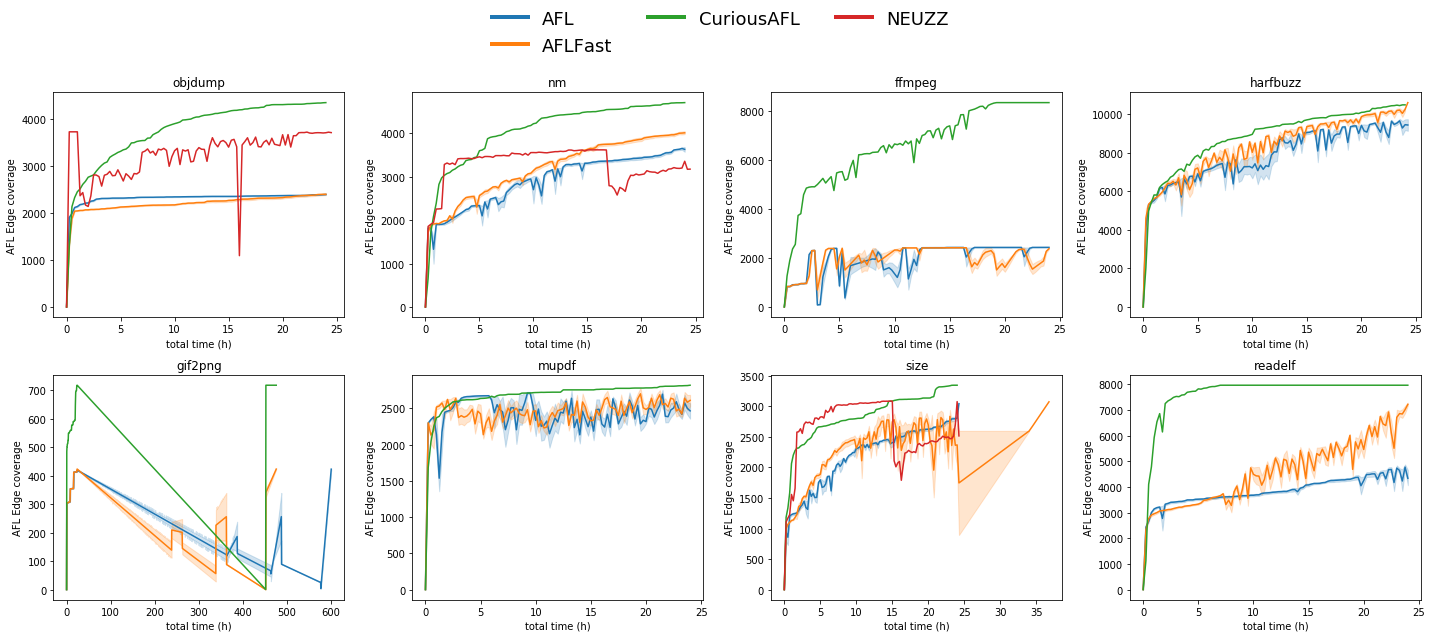

In [75]:
if empty_seed:
    seed='empty_seed'
else:
    seed='premade_seed'
#names = list(results.keys())
#fig, axes =plt.subplots(1,2) #sharey='row' for y-axis sharing
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242)
ax3 = fig.add_subplot(243)
ax4 = fig.add_subplot(244)
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246)
ax7 = fig.add_subplot(247)
ax8 = fig.add_subplot(248)


ax1 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax1, data=results['objdump'])
ax1.set(xlabel='total time (h)', ylabel='AFL Edge coverage')
#ax1.legend()
ax1.title.set_text('objdump')
#ax1.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

ax2 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax2,legend=False, data=results['nm'])
ax2.set(xlabel='total time (h)', ylabel='AFL Edge coverage')
#ax2.legend()
ax2.title.set_text('nm')

ax3 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax3,legend=False, data=results['ffmpeg'])
ax3.set(xlabel='total time (h)', ylabel='AFL Edge coverage')
#ax3.legend()
ax3.title.set_text('ffmpeg')

ax4 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax4,legend=False, data=results['harfbuzz'])
ax4.set(xlabel='total time (h)', ylabel='AFL Edge coverage')
#ax4.legend()
ax4.title.set_text('harfbuzz')

ax5 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax5,legend=False, data=results['gif2png'])
ax5.set(xlabel='total time (h)', ylabel='AFL Edge coverage')
#ax5.legend()
ax5.title.set_text('gif2png')

ax6 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax6,legend=False, data=results['mupdf'])
ax6.set(xlabel='total time (h)', ylabel='AFL Edge coverage')
#ax6.legend()
ax6.title.set_text('mupdf')

ax7 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax7,legend=False, data=results['size'])
ax7.set(xlabel='total time (h)', ylabel='AFL Edge coverage')
#ax7.legend()
ax7.title.set_text('size')

ax8 = sns.lineplot(x="delta_time", y="cur_path", hue='event', ci=60, ax=ax8, legend=False, data=results['readelf'])
ax8.set(xlabel='total time (h)', ylabel='AFL Edge coverage')
#ax8.legend()
ax8.title.set_text('readelf')

handles, labels = ax1.get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center')
#plt.ylabel("afl path coverage")
leg = fig.legend(handles[1:], labels[1:], bbox_to_anchor=(0.5,1.0), loc="lower center",
                 borderaxespad=0, ncol=3, fontsize=18, framealpha=0)

# set the linewidth of each legend object
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
    
ax1.get_legend().remove()
#if empty_seed:
#    fig.suptitle('Path coverage with Empty Seed')
#else:
#    fig.suptitle('Path coverage with Premade Seed')
    
fig.tight_layout() #rrect=[0,0,1,1]

#fig.subplots_adjust(top=0.88)
plt.savefig('./graphs/24h_rawcoverage_'+ seed + '.png', dpi = 200, bbox_inches="tight")
#ax2.figtext(0.5, 0.01, "AFL vs CuriousAFL p=" + str(p), wrap=True, horizontalalignment='center', fontsize=12)

In [2]:
! wormhole send ./graphs/24h_rawcoverage_premade_seed.png

Sending 864.6 kB file named '24h_rawcoverage_premade_seed.png'
Wormhole code is: 2-pandora-indulge
On the other computer, please run:

wormhole receive 2-pandora-indulge

Sending (->relay:tcp:magic-wormhole-transit.debian.net:4001)..
100%|████████████████████████████████████████| 865k/865k [00:00<00:00, 1.00MB/s]
File sent.. waiting for confirmation
Confirmation received. Transfer complete.
